In [1]:
%run VacuumGauge_functions.ipynb

import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow import keras

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.pipeline import Pipeline

## Reading the dataset

- df_ok: labels of ok gauges
- df_delta: labels of delta gauges
- df_ raw: raw data cointaining the full reading of each gauge

In [2]:
df_delta = pd.read_csv('data/datasets/df_delta.csv') # cointains labels for delta VG
df_ok = pd.read_csv('data/datasets/df_ok.csv')  #contains labels for ok VG

df_raw = pd.read_csv('data/datasets/df_raw.csv') ## contains full reading of each VG

df_labels = pd.concat([df_ok, df_delta], sort=False, axis=0)


df_VG = pd.merge(df_raw, df_labels, on =['gauge_id','fillNumber'])
df_VG = df_VG.set_index(['gauge_id','fillNumber'], drop=True)

## Removing categorical values
df_VG.y.replace(to_replace=['ok', 'delta'], value=[0, 1], inplace=True)

## Splitting the dataset in input and target
- X are the input features
- y is the target vector

In [21]:
X = np.array(df_VG.iloc[:, :-1])
y = np.array(df_VG.iloc[:, -1])

## Hold out a test set for final evaluation

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

print(sss)

for train_index, test_index in sss.split(X, y):
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


print(len(y_train))
print(sum(y_train))
print(len(y_test))
print(sum(y_test))

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)
TRAIN size: 222 TEST size: 56
222
111
56
28


### Definition of a StratifiedKFold split to be used on the train set in all the grid search for all the model: 

In [5]:
from sklearn.model_selection import StratifiedKFold

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

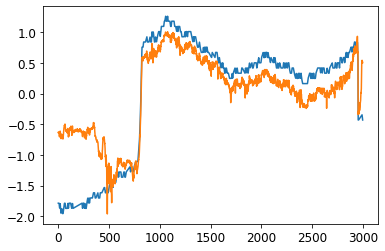

In [6]:
scaler = RowScaler('Standard')
# X_norm = scaler.fit_transform(X)
# X_norm[0].shape

i=100
X_train_m = scaler.fit_transform(X_train) - scaler.fit_transform(X_train).mean(axis=0, keepdims=0)
plt.figure()
plt.plot(range(3000), scaler.fit_transform(X_train)[i])
plt.plot(range(3000), X_train_m[i])
plt.show()

## Quick overview on the PCA impact

PCA performed on the trainig part of the normalised dataset to visualize its impact.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

X_train_pca = pca.fit_transform(scaler.fit_transform(X_train))
X_train_pca[1]

array([57.1072592 , 17.24902627, -2.06532791])

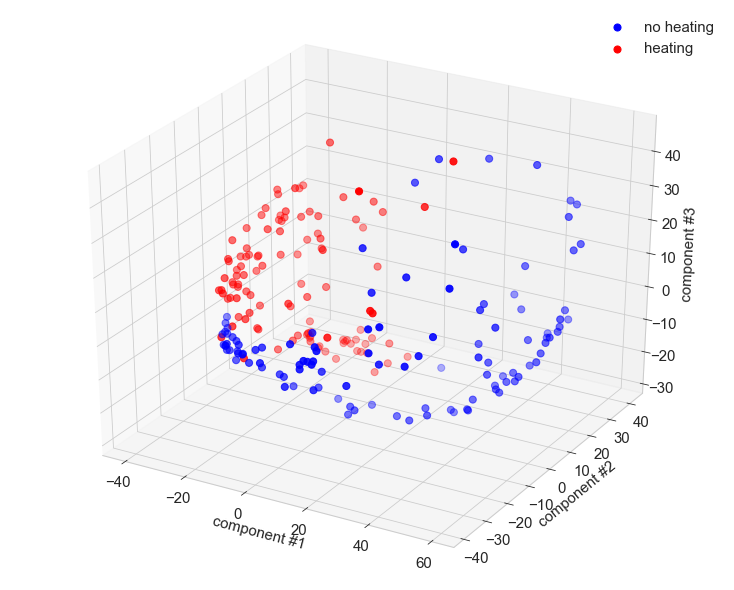

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fontsize=15

ok = X_train_pca[y_train==0]
delta = X_train_pca[y_train ==1]

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

ax.scatter(ok[:,0], ok[:,1], ok[:,2], c='b', label='no heating', s=50)
ax.scatter(delta[:,0], delta[:,1], delta[:,2], c='r', label='heating', s=50)

ax.set_xlabel('component #1', fontsize=fontsize)
ax.set_ylabel('component #2', fontsize=fontsize)
ax.set_zlabel('component #3', fontsize=fontsize)

# ax.set_xlim(-25,30)
# ax.set_ylim(-5,20)
# ax.set_zlim(-10,7.5)
plt.gca().patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()


## Random Forest

In [126]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = Pipeline([
    ('scaler', RowScaler(scaling_method='Standard')),
    ('pca', PCA(n_components=3)),
    ('forest', RandomForestClassifier())

])

model = forest_clf
model_dir = 'data/models/random_forest'
model_version = 'forest_001.pkl'
scoring = ['recall', 'accuracy', 'precision']

forest_path = os.path.join(model_dir, model_version)

print(os.path.join(model_dir,model_version))

data/models/random_forest/forest_001.pkl


### Quick train to get an overview of the model

In [127]:
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split

X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
forest_clf.fit(X_train_forest, y_train_forest)
y_pred = forest_clf.predict(X_test_forest)
print(accuracy_score(y_true=y_test_forest, y_pred=y_pred, sample_weight=None))
print(recall_score(y_true=y_test_forest, y_pred=y_pred, sample_weight=None))

0.9054054054054054
0.8444444444444444


#### GridSearch

In [128]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'scaler__scaling_method': RowScaler().scaling_options,
     'pca__n_components': range(2,6),
     'forest__n_estimators': range(100,200,20),
     'forest__max_leaf_nodes': range(3,8),
     'forest__bootstrap': [False],
    }
]


In [129]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X_train, y_train)

# Tuning hyper-parameters for recall and accuracy

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 10.1min finished
/Users/Francesco/anaconda3/envs/my_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        RowScaler(scaling_method='Standard')),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=3, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('forest',
                                        RandomForestClassifier(bootstrap...
             iid='warn', n_jobs=-1,
             param_grid=[{'forest__bootstrap': [False],
                          'forest__max_leaf_nodes': range(3, 8),
                          'forest__n_estimators': range(100, 200, 20),
              

In [111]:
#printGridSearchResults(grid_search, scoring[0])

In [130]:
grid_search.best_score_

0.9459459459459459

### Saving the model

In [131]:
save_model(grid_search, model_dir, model_version)

data/models/random_forest/forest_001.pkl succesfully saved.


## Logistic Regressor (classifier)

In [9]:
from sklearn.linear_model import LogisticRegression

log_clf = Pipeline([
    ('scaler', RowScaler(scaling_method='Standard')),
    ('pca', PCA(n_components=3)),
    ('logistic', LogisticRegression())

])

model = log_clf
model_dir = 'data/models/logistic_classifier'
model_version = 'logistic_001.pkl'
scoring = ['recall', 'accuracy', 'precision']

log_path = os.path.join(model_dir, model_version)

print(os.path.join(model_dir, model_version))

data/models/logistic_classifier/logistic_001.pkl


In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'scaler__scaling_method': RowScaler().scaling_options,
     'pca__n_components': range(2,6),
    }
]

In [11]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X_train, y_train)

# Tuning hyper-parameters for recall and accuracy

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   12.3s finished
/Users/Francesco/anaconda3/envs/my_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        RowScaler(scaling_method='Standard')),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=3, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('logistic',
                                        LogisticRegression(C=1.0,
                                                           class...
                                                           n_jobs=None,
                                                           penalty='l2',
                                     

In [12]:
printGridSearchResults(grid_search, scoring[0])

Best parameters set found on development set:
{'pca__n_components': 4, 'scaler__scaling_method': 'MinMax'}

Grid scores on development set:

0.928 (+/-0.072) for {'pca__n_components': 2, 'scaler__scaling_method': 'Standard'}
0.892 (+/-0.122) for {'pca__n_components': 2, 'scaler__scaling_method': 'MinMax'}
0.748 (+/-0.212) for {'pca__n_components': 2, 'scaler__scaling_method': 'MaxAbs'}
0.883 (+/-0.133) for {'pca__n_components': 2, 'scaler__scaling_method': 'Robust'}
0.937 (+/-0.071) for {'pca__n_components': 3, 'scaler__scaling_method': 'Standard'}
0.946 (+/-0.066) for {'pca__n_components': 3, 'scaler__scaling_method': 'MinMax'}
0.946 (+/-0.037) for {'pca__n_components': 3, 'scaler__scaling_method': 'MaxAbs'}
0.901 (+/-0.117) for {'pca__n_components': 3, 'scaler__scaling_method': 'Robust'}
0.937 (+/-0.071) for {'pca__n_components': 4, 'scaler__scaling_method': 'Standard'}
0.955 (+/-0.055) for {'pca__n_components': 4, 'scaler__scaling_method': 'MinMax'}
0.946 (+/-0.037) for {'pca__n_com

In [13]:
grid_search.best_score_

0.954954954954955

### Saving the model

In [14]:
#print(grid_search)
save_model(grid_search, model_dir, model_version)

data/models/logistic_classifier/logistic_001.pkl already exist, not overwritten.


## KNN

In [133]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = Pipeline([
    ('scaler', RowScaler(scaling_method='Standard')),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())

])

model = knn_clf
model_dir = 'data/models/knn'
model_version = 'knn_001.pkl'
scoring = ['recall', 'accuracy', 'precision']

knn_path = os.path.join(model_dir, model_version)
print(os.path.join(model_dir, model_version))

data/models/knn/knn_001.pkl


In [134]:
param_grid = [
    {'scaler__scaling_method': RowScaler().scaling_options,
     'pca__n_components': range(2,6),
     'knn__n_neighbors': range(3,7),
     'knn__n_jobs': [-1]
    }
]

In [135]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X_train, y_train)

# Tuning hyper-parameters for recall and accuracy

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  1.4min finished
/Users/Francesco/anaconda3/envs/my_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        RowScaler(scaling_method='Standard')),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='...
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                ve

In [ ]:
printGridSearchResults(grid_search, scoring[0])

In [136]:
grid_search.best_score_

0.963963963963964

In [137]:
save_model(grid_search, model_dir, model_version)

data/models/knn/knn_001.pkl succesfully saved.


## CNN 

In [36]:
print(X_train.shape)
model = keras.models.Sequential([
    
])
model.summary()

(222, 3000)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, None, 1)           0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [55]:
keras.backend.clear_session()

def build_CNN(filters=15, kernel_size=20, learning_rate=0.05):
    model = keras.models.Sequential()
    mode.add(keras.layers.Reshape((3000, 1), input_shape=[3000]))
    model.add(keras.layers.Conv1D(filters=filters, kernel_size=kernel_size,
              activation='relu', padding='same', use_bias=True))
    model.add(keras.layers.MaxPool1D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=100, activation='relu'))
    model.add(keras.layers.Dense(units=1, activation='sigmoid'))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy',
                            optimizer=keras.optimizers.Adam(learning),
                            metrics=[keras.metrics.Recall()])
    return model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3000, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3000, 15)          315       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1500, 15)          0         
_________________________________________________________________
flatten (Flatten)            (None, 22500)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2250100   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,250,516
Trainable params: 2,250,516
Non-trainable params: 0
______________________________________________

In [59]:
scaler = RowScaler(scaling_method='Standard')
history =  model.fit(scaler.fit_transform(X_train), y_train, epochs=100,
                     validation_data=(scaler.fit_transform(X_test), y_test),
                     callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Train on 222 samples, validate on 56 samples
Epoch 1/100
222/222 [==============================] - 1s 3ms/sample - loss: 0.0602 - recall: 0.9640 - val_loss: 0.1517 - val_recall: 0.9643
Epoch 2/100
222/222 [==============================] - 1s 3ms/sample - loss: 0.0366 - recall: 0.9820 - val_loss: 0.1287 - val_recall: 0.9643
Epoch 3/100
222/222 [==============================] - 1s 3ms/sample - loss: 0.0327 - recall: 0.9910 - val_loss: 0.1477 - val_recall: 0.9643
Epoch 4/100
222/222 [==============================] - 1s 3ms/sample - loss: 0.0310 - recall: 0.9820 - val_loss: 0.1191 - val_recall: 0.9643
Epoch 5/100
222/222 [==============================] - 1s 3ms/sample - loss: 0.0352 - recall: 0.9910 - val_loss: 0.1076 - val_recall: 0.9643
Epoch 6/100
222/222 [==============================] - 1s 3ms/sample - loss: 0.0120 - recall: 0.9910 - val_loss: 0.1953 - val_recall: 0.9643
Epoch 7/100
222/222 [==============================] - 1s 3ms/sample - loss: 0.0301 - recall: 0.9820 - val_lo

In [56]:
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [57]:
keras_clf.fit(X_train, y_train, epochs= 10)

Train on 222 samples
Epoch 1/10
222/222 [==============================] - 1s 6ms/sample - loss: 0.6930 - recall: 0.2793
Epoch 2/10
222/222 [==============================] - 1s 3ms/sample - loss: 0.6946 - recall: 0.0000e+00
Epoch 3/10
222/222 [==============================] - 1s 3ms/sample - loss: 0.6932 - recall: 0.0000e+00
Epoch 4/10
222/222 [==============================] - 1s 3ms/sample - loss: 0.6936 - recall: 0.1261
Epoch 5/10
222/222 [==============================] - 1s 3ms/sample - loss: 0.6932 - recall: 1.0000
Epoch 6/10
222/222 [==============================] - 1s 3ms/sample - loss: 0.6934 - recall: 1.0000
Epoch 7/10
222/222 [==============================] - 1s 3ms/sample - loss: 0.6932 - recall: 1.0000
Epoch 8/10
222/222 [==============================] - 1s 3ms/sample - loss: 0.6933 - recall: 1.0000
Epoch 9/10
222/222 [==============================] - 1s 3ms/sample - loss: 0.6932 - recall: 1.0000
Epoch 10/10
222/222 [==============================] - 1s 3ms/sample - 

In [116]:
# y_pred = grid_search.best_estimator_.predict(X_test)

# from sklearn.metrics import recall_score, precision_score, accuracy_score

# recall_score(y_test, y_pred)

0.8571428571428571